This first part is used to create the binary encoding out of the data. It reads the cluster data along with aggregated data and goals

In [47]:
import pandas as pd

data = pd.read_csv("../../data/interim/player_season_stats_23-24_relevant.csv")
goal_data = pd.read_csv('../../data/interim/player_season_stats_23-24.csv', sep=',', encoding="latin1")

Aggregating the fines and storing them as CSV

In [48]:
aggregated_goals = goal_data.groupby('player', as_index=False).agg({
    'Gls': 'sum',    # sum goals
    'Ast': 'sum',    # sum assists
    'player': 'first'  # keep the first occurrence of Name
})

#Save aggregated goals to a new csv file
aggregated_goals.to_csv('../../data/processed/aggregated_goals.csv', index=False)

#Aggregate data by player
categorical_cols = ['league', 'season',	'team',	'player', 'nation',	'pos',	'age']

sum_numeric_cols = ['MP Playing Time', 'Min Playing Time', 'KP',	'PrgP',	'PPA',	'CrsPA', 'Att Long', 'TB Pass Types', 'Sw Pass Types', 'Crs Pass Types', 'PrgC Carries', 'CPA Carries',	'Succ Take-Ons',    'Dis Carries',	'Mis Carries',	'PrgR Receiving', 'TklW Tackles', 'Att 3rd Tackles', 'Mid 3rd Tackles',	'Def 3rd Tackles',	'Int',	'Sh Blocks', 'Recov Performance', 'Won Aerial Duels', 'Fls Performance', 'Fld Performance', 'Att Pen Touches', 'Att 3rd Touches', 'Mid 3rd Touches', 'Def 3rd Touches',	'Def Pen Touches', 'Live Touches',	'Cmp Total']
average_cols = ['90s Playing Time',	'npxG Per 90 Minutes',	'G-PK Per 90 Minutes',	'xAG Per 90 Minutes',	'xG+xAG Per 90 Minutes',	'Sh/90 Standard',	'SoT% Standard',	'Dist Standard',	'G/Sh Standard',	'Cmp% Total',	'Cmp% Long',	'Succ% Take-Ons', 'Won% Aerial Duels']

aggregated_data = data.groupby('player', as_index=False).agg({
    **{col: 'first' for col in categorical_cols},  # keep the first occurrence of categorical columns
    **{col: 'sum' for col in sum_numeric_cols},        # sum numeric columns
    **{col: 'mean' for col in average_cols}        # average specified columns 
})

#save aggregated data to a new csv file
aggregated_data.to_csv('../../data/processed/aggregated_data.csv', index=False)

Read the cluster data and merge everything for binary encoding

In [49]:

data = pd.read_csv('../../data/processed/aggregated_data.csv', sep=',', encoding="latin1")
clustered_data = pd.read_csv('../../data/processed/players_w_clusters.csv', sep=',', encoding="latin1")
goal_data = pd.read_csv('../../data/processed/aggregated_goals.csv', sep=',', encoding="latin1")

# Merge cluster labels by player name
data = data.merge(clustered_data[['player', 'cluster']], on='player', how='left')
cols = list(data.columns)
# Remove cluster and reinsert at index 2
cols.insert(2, cols.pop(cols.index('cluster')))
# Reorder dataframe
data = data[cols]

# Merge goals and assists by player name
data = data.merge(goal_data[['player', 'Gls']], on='player', how='left')
data = data.merge(goal_data[['player', 'Ast']], on='player', how='left')

#Store the headers in a list
headers = data.columns.tolist()
filtered_data = data.copy()


Data manipulation to only take big group clusters

In [50]:
#Group the data by cluster
clustered_grouped_data = filtered_data.groupby('cluster')

#Remove clusters with less than 50 from filtered data
cluster_sizes = clustered_grouped_data.size()
clusters_to_keep = cluster_sizes[cluster_sizes >= 50].index
filtered_data = filtered_data[filtered_data['cluster'].isin(clusters_to_keep)]

#Group the data by cluster
clustered_grouped_data = filtered_data.groupby('cluster')

#Print the number of players in each cluster 
for cluster, group in clustered_grouped_data:
    num_players = len(group)
    print(f"Cluster: {cluster}, Number of players: {num_players}")


Cluster: 0.0, Number of players: 581
Cluster: 4.0, Number of players: 346
Cluster: 5.0, Number of players: 801
Cluster: 8.0, Number of players: 286
Cluster: 9.0, Number of players: 242
Cluster: 16.0, Number of players: 105


Transform into binary encoding

In [51]:
#Calculate the 90th percentile for each stat in each cluster
stats = headers[8:]
result = {}

# Loop through clusters and stats
for cluster, group in clustered_grouped_data:
    result[cluster] = {}
    for stat in stats:
        result[cluster][stat] = group[stat].quantile(0.90)

#Transform data into binary format based on 90th percentile
binary_data = filtered_data.copy()
for cluster in result:
    for stat in stats:
        threshold = result[cluster][stat]
        binary_data.loc[binary_data['cluster'] == cluster, stat] = binary_data.loc[binary_data['cluster'] == cluster, stat].apply(lambda x: 1 if x >= threshold else 0)

#Save the binary data to a new CSV file
binary_data.to_csv('../../data/processed/binary_encoded_player_stats_2.csv', index=False)

Import libraries for Analysis and read code

In [57]:
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
bin_data = pd.read_csv('../../data/processed/binary_encoded_player_stats_2.csv', sep=',', encoding="latin1")

# Dictionary to store cluster-wise stat metrics
cluster_stats = {'cluster': [], 'stat': [], 'lift': [], 'confidence': []}

Calculate Dynamic Support 

In [58]:
#Convert all columns except 'player', 'team', 'league', 'season', 'nation', 'pos', 'age', 'cluster', 'Gls', 'Ast' to boolean
cols_to_convert = [col for col in bin_data.columns if col not in ['player', 'team', 'league', 'season', 'nation', 'pos', 'age', 'cluster', 'Gls', 'Ast']]
bin_data[cols_to_convert] = bin_data[cols_to_convert].astype(bool)


# Group the data by cluster
clustered = bin_data.groupby('cluster')
Goals_rate = []  # Define a threshold for goals to consider

# Function to calculate dynamic min_support
def compute_dynamic_support(cluster_size):
    return max(0.03, 5 / cluster_size)

# Dictionary to store min_support per cluster
dynamic_supports = {}

for cluster, group in clustered:
    size = len(group)
    gls_count = group['Gls'].sum()
    goal_rate = gls_count / size
    min_sup = compute_dynamic_support(size)
    dynamic_supports[cluster] = min_sup
    Goals_rate.append(goal_rate)
    print(f"Cluster: {cluster}, Size: {size}, Goals: {gls_count}, Goal Rate: {goal_rate:.2f}, Min Support: {min_sup:.4f}")




Cluster: 0.0, Size: 581, Goals: 448.0, Goal Rate: 0.77, Min Support: 0.0300
Cluster: 4.0, Size: 346, Goals: 30.0, Goal Rate: 0.09, Min Support: 0.0300
Cluster: 5.0, Size: 801, Goals: 66.0, Goal Rate: 0.08, Min Support: 0.0300
Cluster: 8.0, Size: 286, Goals: 25.0, Goal Rate: 0.09, Min Support: 0.0300
Cluster: 9.0, Size: 242, Goals: 19.0, Goal Rate: 0.08, Min Support: 0.0300
Cluster: 16.0, Size: 105, Goals: 76.0, Goal Rate: 0.72, Min Support: 0.0476


APRIORI algorithm

In [59]:
index = 0

for cluster, group in clustered:

    if Goals_rate[index] >0.15:
        index += 1
        continue    

    print(f"\n------- CLUSTER {cluster} -------")

    cluster_data = group.drop(columns=[
        'cluster','league','player','season',
        'team','nation','pos','age'
    ])
    support_threshold = dynamic_supports[cluster]

    # Apriori (must allow 2-item sets!)
    frequent_itemsets = apriori(
        cluster_data,
        min_support=support_threshold,
        use_colnames=True,
        max_len=2
    )

    # Association rules
    rules = association_rules(
        frequent_itemsets,
        metric="confidence",
        min_threshold=0.3
    )

    if rules.empty:
        print("No rules generated for this cluster.")
        continue

    # Remove rules with lift < 1
    rules = rules[rules['lift'] >= 1]

    if rules.empty:
        print("No rules with lift >= 1.")
        continue

    # Keep only rules where consequent == {Gls}
    rules_to_goals = rules[
        rules['consequents'].apply(lambda x: len(x) == 1 and 'Gls' in x)
    ]

    if rules_to_goals.empty:
        print("No rules implying Gls.")
        continue

    # Keep only single-stat antecedents
    rules_to_goals = rules_to_goals[
        rules_to_goals['antecedents'].apply(lambda a: len(a) == 1)
    ]

    if rules_to_goals.empty:
        print("No single-stat rules implying Gls.")
        continue

    # Store
    for _, row in rules_to_goals.iterrows():
        stat = list(row['antecedents'])[0]
        cluster_stats['cluster'].append(cluster)
        cluster_stats['stat'].append(stat)
        cluster_stats['lift'].append(row['lift'])
        cluster_stats['confidence'].append(row['confidence'])

    #print("\nSingle-stat rules implying goals:")
   # print(rules_to_goals[['antecedents','consequents','support','confidence','lift']])

    # Ranking
    stats = [list(a)[0] for a in rules_to_goals['antecedents']]
    lifts = rules_to_goals['lift'].tolist()
    lift_df = pd.DataFrame({'stat': stats, 'lift': lifts})
    lift_df = lift_df.groupby('stat').sum().sort_values('lift', ascending=False)

    print("\nStats ranked by lift (single-stat influence):")
    print(lift_df.head(10))
    index += 1


------- CLUSTER 4.0 -------

Stats ranked by lift (single-stat influence):
                         lift
stat                         
G-PK Per 90 Minutes  6.087037
G/Sh Standard        4.856140

------- CLUSTER 5.0 -------


c:\Users\praga\Miniconda3\envs\dtu02450\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\praga\Miniconda3\envs\dtu02450\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Stats ranked by lift (single-stat influence):
                           lift
stat                           
G-PK Per 90 Minutes    7.042088
Att Pen Touches        5.543771
npxG Per 90 Minutes    5.221459
xG+xAG Per 90 Minutes  5.032151
G/Sh Standard          4.515856
Ast                    4.100123
Mis Carries            3.801752

------- CLUSTER 8.0 -------

Stats ranked by lift (single-stat influence):
                      lift
stat                      
Att Pen Touches   6.101333
Att 3rd Touches   5.917241
Mis Carries       5.917241
PrgR Receiving    5.720000
Min Playing Time  5.522759
MP Playing Time   5.402222
Fls Performance   5.200000
Dis Carries       5.128276
90s Playing Time  5.128276
Ast               4.853333

------- CLUSTER 9.0 -------

Stats ranked by lift (single-stat influence):
                      lift
stat                      
Att Pen Touches   5.878543
90s Playing Time  5.094737
Min Playing Time  5.094737
Att 3rd Tackles   4.585263
Live Touches      4.585263


c:\Users\praga\Miniconda3\envs\dtu02450\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\praga\Miniconda3\envs\dtu02450\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\praga\Miniconda3\envs\dtu02450\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Visuialization

    cluster                   stat      lift  confidence
0       4.0    G-PK Per 90 Minutes  6.087037    0.527778
1       4.0          G/Sh Standard  4.856140    0.421053
2       5.0            Mis Carries  3.801752    0.313253
3       5.0        Att Pen Touches  5.543771    0.456790
4       5.0    npxG Per 90 Minutes  5.221459    0.430233
5       5.0    G-PK Per 90 Minutes  7.042088    0.580247
6       5.0  xG+xAG Per 90 Minutes  5.032151    0.414634
7       5.0          G/Sh Standard  4.515856    0.372093
8       5.0                    Ast  4.100123    0.337838
9       8.0        MP Playing Time  5.402222    0.472222
10      8.0       Min Playing Time  5.522759    0.482759
11      8.0                     KP  3.495556    0.305556
12      8.0            CPA Carries  4.797419    0.419355
13      8.0            Dis Carries  5.128276    0.448276
14      8.0            Mis Carries  5.917241    0.517241
15      8.0         PrgR Receiving  5.720000    0.500000
16      8.0       Won Aerial Du

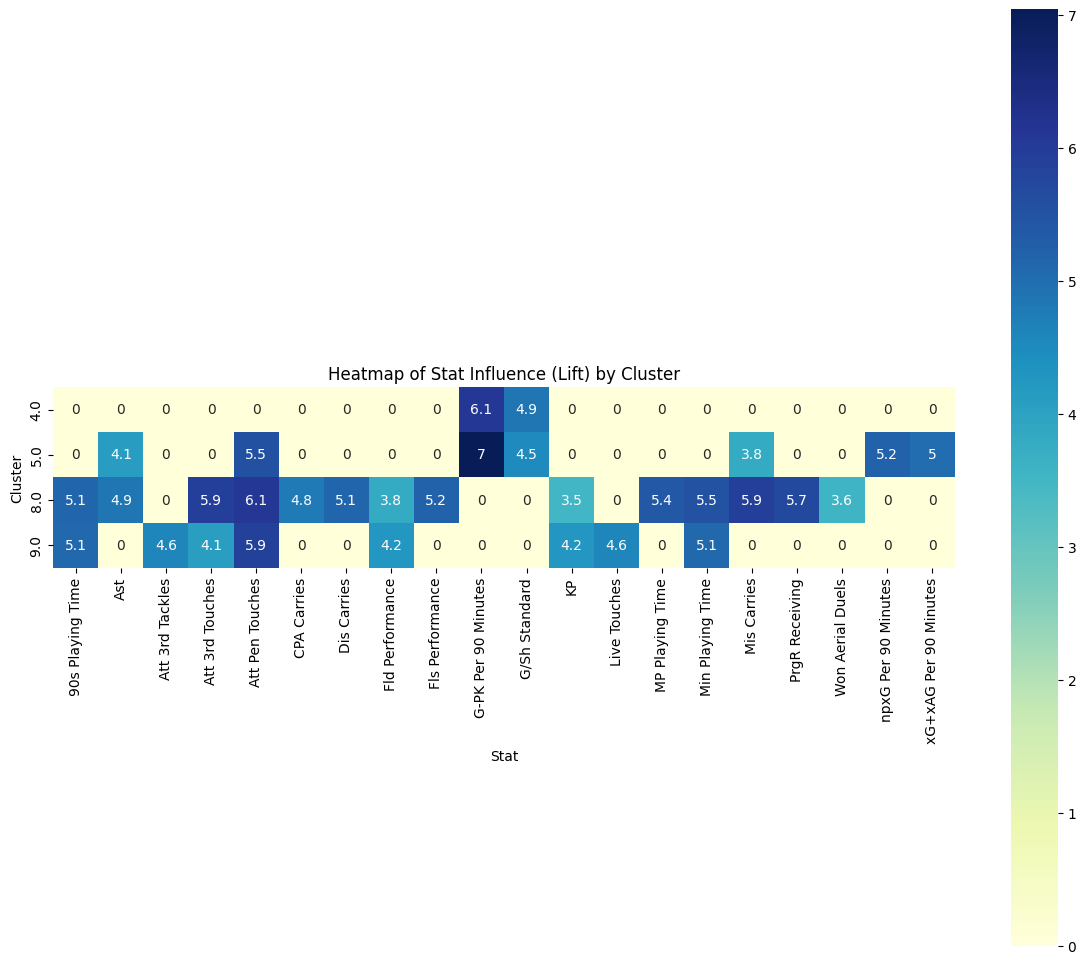

In [60]:
# Create a DataFrame for cluster-wise stat metrics
cluster_stats_df = pd.DataFrame(cluster_stats)
print(cluster_stats_df)

#Display table where each row is a cluster and each column is a st
pivot_table = cluster_stats_df.pivot(index='cluster', columns='stat', values='lift').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", square=True, cbar_kws={"shrink": 0.8})
plt.title("Heatmap of Stat Influence (Lift) by Cluster")
plt.xlabel("Stat")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()